In [1]:
#import all necessary libraries for the project
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import glob
import os
import cv2
from sklearn.svm import SVC

In [2]:
#direct the path to the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path1='drive/MyDrive/STATS302_FINAL_PROJECT'

In [4]:
data=pd.read_csv(path1+'/final_label_2.csv')
data['tag'].unique()

array([1, 2, 0])

In [5]:
#convert the label to a numpy array
label=np.array(data['tag'])
ylabel=label.reshape(2087,1)
ylabel

array([[1],
       [2],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [6]:
path_original = "drive/MyDrive/STATS302_FINAL_PROJECT/final_segment_images"
path_without = "drive/MyDrive/STATS302_FINAL_PROJECT/without_final"
path_incorrect = "drive/MyDrive/STATS302_FINAL_PROJECT/incorrect_final"

In [7]:
#designate the paths for all images
path1 = glob.glob(os.path.join(path_original, '*.png'))
path1

path2 = glob.glob(os.path.join(path_without, '*.png'))
path2
path = path1 + path2

path3 = glob.glob(os.path.join(path_incorrect, '*.png'))
path3
path = path + path3

In [8]:
#create the matrix for all images
img_list = []
# img = cv2.imread(path[0])
# img
for file in path:
  img = cv2.imread(file)
  img = (img/255.0)
  img_list.append(img)
img_list = np.array(img_list)
img_list

array([[[[0.14509804, 0.12941176, 0.1254902 ],
         [0.14509804, 0.12941176, 0.1254902 ],
         [0.14509804, 0.12941176, 0.1254902 ],
         ...,
         [0.15294118, 0.14117647, 0.14901961],
         [0.15294118, 0.14117647, 0.14901961],
         [0.15294118, 0.14117647, 0.14901961]],

        [[0.14509804, 0.12941176, 0.1254902 ],
         [0.14509804, 0.12941176, 0.1254902 ],
         [0.14509804, 0.12941176, 0.1254902 ],
         ...,
         [0.15294118, 0.14117647, 0.14901961],
         [0.15294118, 0.14117647, 0.14901961],
         [0.15294118, 0.14117647, 0.14901961]],

        [[0.14509804, 0.12941176, 0.1254902 ],
         [0.14509804, 0.12941176, 0.1254902 ],
         [0.14509804, 0.12941176, 0.1254902 ],
         ...,
         [0.14901961, 0.1372549 , 0.14509804],
         [0.14901961, 0.1372549 , 0.14509804],
         [0.14901961, 0.1372549 , 0.14509804]],

        ...,

        [[0.29803922, 0.28627451, 0.34509804],
         [0.29803922, 0.28627451, 0.34509804]

In [9]:
img_list.shape

(2087, 128, 128, 3)

In [10]:
#count the distinct variables
(unique, counts) = np.unique(ylabel, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print (frequencies)
print (len(unique))

[[  0 536]
 [  1 821]
 [  2 730]]
3


In [11]:
#define different categories
class_types=['incorrect_wear','with_mask','without_mask']

In [12]:
#convert all variables to dummy variables
train_lab_categorical = tf.keras.utils.to_categorical(
    ylabel, num_classes=3, dtype='uint8')
print(train_lab_categorical)

[[0 1 0]
 [0 0 1]
 [0 1 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [13]:
#split training set and test set (for both orginal labels and dummied labels)
from sklearn.model_selection import train_test_split 
train_im, test_im, train_lab, test_lab = train_test_split(img_list, train_lab_categorical, test_size=0.3, 
                                                            stratify=train_lab_categorical,
                                                            random_state=100, shuffle = True)
train_im2, test_im2, train_lab2, test_lab2 = train_test_split(img_list, ylabel, test_size=0.20,                                                            
                                                            random_state=40, shuffle = True)
print ("train data shape after the split: ", train_im.shape)
print ('new test data shape: ', test_im.shape)
print ("test labels shape: ", test_lab.shape)
train_lab

train data shape after the split:  (1460, 128, 128, 3)
new test data shape:  (627, 128, 128, 3)
test labels shape:  (627, 3)


array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]], dtype=uint8)

In [14]:
#import necessary libraries for the dataset
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras import regularizers

In [15]:
##### Include Little Data Augmentation 
batch_size = 64 # try several values

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(train_im, train_lab, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(test_im, test_lab, batch_size=batch_size) # so as valid_lab 

In [16]:
#define identity unit for the network
def res_identity(x, filters): 

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [17]:
#define convolutionary layers
def res_conv(x, s, filters):

  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [18]:
### Combine the above functions to build 50 layers resnet. 
def resnet50():

  input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)

  x = Dense(len(class_types),activation='softmax',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(x)

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [19]:
### Define some Callbacks
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
  # if epoch < 40:
  #   return 0.01
  # else:
  #   return 0.01 * np.math.exp(0.03 * (40 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  


def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
  return estop    

In [20]:
resnet50_model = resnet50()

In [21]:
#show the structure of the network
resnet50_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
___________________________________________________________________________________________

In [22]:
#add optimizer, loss function and quality metrics to the model.
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), 
                       metrics=['acc'])

In [ ]:
#Run the model
batch_size=batch_size 

resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=40, 
                                  steps_per_epoch=train_im.shape[0]/batch_size, 
                                  validation_steps=test_im.shape[0]/batch_size, 
                                  validation_data=valid_set_conv,
                                  callbacks=[lrdecay])

Epoch 1/40
22/22 [==============================] - 346s 15s/step - loss: 20.7957 - acc: 0.6877 - val_loss: 19.4361 - val_acc: 0.3509
Epoch 2/40
22/22 [==============================] - 339s 15s/step - loss: 18.4019 - acc: 0.9041 - val_loss: 19.1397 - val_acc: 0.3493
Epoch 3/40
22/22 [==============================] - 338s 15s/step - loss: 17.4199 - acc: 0.9295 - val_loss: 17.9314 - val_acc: 0.3493
Epoch 4/40
22/22 [==============================] - 339s 15s/step - loss: 16.4370 - acc: 0.9301 - val_loss: 17.1459 - val_acc: 0.3493
Epoch 5/40
22/22 [==============================] - 338s 15s/step - loss: 15.3745 - acc: 0.9363 - val_loss: 15.8627 - val_acc: 0.3573
Epoch 6/40
22/22 [==============================] - 338s 15s/step - loss: 14.3526 - acc: 0.9411 - val_loss: 15.0378 - val_acc: 0.3493
Epoch 7/40
22/22 [==============================] - 338s 15s/step - loss: 13.3557 - acc: 0.9507 - val_loss: 13.9796 - val_acc: 0.3493
Epoch 8/40
22/22 [==============================] - 338s 15s/s

In [25]:
#extract the last dense layer from the trained models
representation_model = Model(inputs=resnet50_model.inputs, outputs=resnet50_model.get_layer('flatten').output)

In [26]:
#apply the layer to every ovservation
representation_model_output = representation_model.predict(train_im2)

In [27]:
representation_model_output.shape

(1669, 8192)

In [28]:
representation_model_output_test = representation_model.predict(test_im2)

In [29]:
from sklearn.svm import SVC
svm=SVC(kernel='rbf',C=0.1)

In [ ]:
#from sklearn.decomposition import PCA
#pca=PCA(n_components=2)
#train_PCA=pca.fit_transform(representation_model_output)


In [31]:
from sklearn.metrics import accuracy_score
#test_PCA=pca.fit_transform(representation_model_output_test)
svm.fit(representation_model_output,train_lab2)
predicts=svm.predict(representation_model_output_test)
accuracy_score(test_lab2,predicts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9425837320574163

In [32]:
#construct the confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(test_lab2, predicts)
matrix

array([[100,   4,   3],
       [  6, 140,   3],
       [  6,   2, 154]])

In [33]:
#define a funcation that could draw confusion matrix
def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]   
    plt.imshow(cm, interpolation='nearest')   
    plt.title(title)    
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    
    plt.yticks(num_local, labels_name)    
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

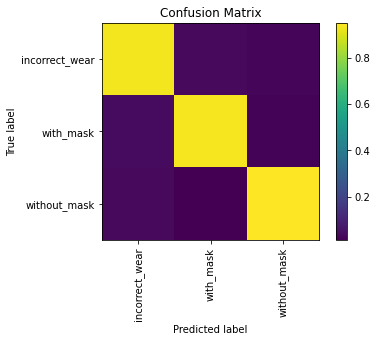

In [35]:
#draw the confusion matrix plot
plot_confusion_matrix(matrix, class_types, "Confusion Matrix")
# plt.savefig('/HAR_cm.png', format='png')
plt.show()